## This notebook answers the Question 3 - Does the Complaint Type that you identified in response to Question 1 have an obvious relationship with any particular characteristic or characteristic of the Houses?

In [1]:
!pip install --upgrade pip


Requirement already up-to-date: pip in /Applications/anaconda/lib/python3.5/site-packages (19.1.1)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
##%%capture                
##! pip install seaborn    
import seaborn as sns
%matplotlib inline    
!pip install Folium
import folium
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

np.random.seed(0)


## Pull the 311 Complaint data and pluto data from the file that I have stored in the Cloud object store.


In [4]:
# NYC complaint dataset
df_311 = pd.read_csv('./data/NYCdata.csv')

In [7]:

# Create a Dataframe out of the pluto datasets:

df_BK = pd.read_csv('./data/BK_18v1.csv')
df_BX= pd.read_csv('./data/BX_18v1.csv')
df_MN = pd.read_csv('./data/MN_18v1.csv')
df_QN = pd.read_csv('./data/QN_18v1.csv')

/Applications/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,20,22,23,24,25,26,64,65,80) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Applications/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,20,22,23,64,65,80) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Applications/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (20,23,24,26,64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Applications/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,20,22,23,64,65,77) have mixed types. Specify dtype option o

In [8]:
# Selecting column with maximum compaints incdent zip (BK: Brooklyn) given in PLUTO dataset 
# I am excluding Staten Isaland borough as it has very low number of complaints

df_data_BK_1 = df_BK[['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'Lot', 
'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 
'YearBuilt', 'YearAlter1', 'ZipCode', 'YCoord', 'XCoord']]

df_data_BK_1 = df_data_BK_1.dropna()

# Selecting column with maximum compaints incdent zip (BX) given in PLUTO dataset 


df_data_BX_1 = df_BX[['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'Lot', 
'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 
'YearBuilt', 'YearAlter1', 'ZipCode', 'YCoord', 'XCoord']]

df_data_BX_1 = df_data_BX_1.dropna()

# Selecting column with maximum compaints incdent zip (MN) given in PLUTO dataset 


df_data_MN_1 = df_MN[['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'Lot', 
'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 
'YearBuilt', 'YearAlter1', 'ZipCode', 'YCoord', 'XCoord']]

df_data_MN_1 = df_data_MN_1.dropna()

# Selecting column with maximum compaints incdent zip (QN) given in PLUTO dataset 


df_data_QN_1 = df_QN[['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'Lot', 
'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 
'YearBuilt', 'YearAlter1', 'ZipCode', 'YCoord', 'XCoord']]

df_data_QN_1 = df_data_QN_1.dropna()


In [9]:

frames = [df_data_BK_1, df_data_BX_1, df_data_MN_1, df_data_QN_1]

df_pluto = pd.concat(frames)

df_pluto.index = range(len(df_pluto.index))

df_pluto.shape

(718872, 20)

In [10]:
print(df_311.columns)
print(df_pluto.columns)

Index(['address_type', 'borough', 'city', 'closed_date', 'complaint_type',
       'created_date', 'incident_address', 'incident_zip', 'latitude',
       'location_type', 'longitude', 'resolution_description', 'status',
       'street_name', 'unique_key'],
      dtype='object')
Index(['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR',
       'Lot', 'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea',
       'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1',
       'ZipCode', 'YCoord', 'XCoord'],
      dtype='object')


In [11]:
# merging HEATING and HEAT/HOT WATER as one feature
df_311['complaint_type'] = np.where(df_311['complaint_type']=='HEATING','HEAT/HOT WATER',df_311['complaint_type'])
df_complaint = df_311.loc[df_311['complaint_type']=='HEAT/HOT WATER'].dropna()
df_complaint.head()

,address_type,borough,city,closed_date,complaint_type,created_date,incident_address,incident_zip,latitude,location_type,longitude,resolution_description,status,street_name,unique_key
154,ADDRESS,QUEENS,Ridgewood,2019-03-30T08:11:05.000,HEAT/HOT WATER,2019-03-25T16:31:21.000,71-21 65 STREET,11385.0,40.701989,RESIDENTIAL BUILDING,-73.890577,The Department of Housing Preservation and Dev...,Closed,65 STREET,42049572
155,ADDRESS,BROOKLYN,BROOKLYN,2019-03-28T02:08:55.000,HEAT/HOT WATER,2019-03-26T21:10:48.000,10412 AVENUE L,11236.0,40.642237,RESIDENTIAL BUILDING,-73.889760,The Department of Housing Preservation and Dev...,Closed,AVENUE L,42061623
157,ADDRESS,QUEENS,Astoria,2019-03-30T02:06:02.000,HEAT/HOT WATER,2019-03-27T04:36:22.000,31-35 CRESCENT STREET,11106.0,40.764684,RESIDENTIAL BUILDING,-73.927184,The Department of Housing Preservation and Dev...,Closed,CRESCENT STREET,42064133
160,ADDRESS,BRONX,BRONX,2019-03-30T02:08:48.000,HEAT/HOT WATER,2019-03-27T17:52:17.000,930 FOX STREET,10459.0,40.820637,RESIDENTIAL BUILDING,-73.893872,The Department of Housing Preservation and Dev...,Closed,FOX STREET,42065237
161,ADDRESS,BRONX,BRONX,2019-03-30T02:06:18.000,HEAT/HOT WATER,2019-03-27T21:16:20.000,3525 DECATUR AVENUE,10467.0,40.879228,RESIDENTIAL BUILDING,-73.872353,The complaint you filed is a duplicate of a co...,Closed,DECATUR AVENUE,42065248


In [12]:
df_target = df_pluto[['Address']].isin(df_complaint['incident_address'].unique())
print(df_target['Address'].sum())
df_target = (df_target['Address'])*1
df_target.dtypes

99796


dtype('int64')

In [13]:
df_pluto.loc[:,'target'] = df_target
df_pluto.head()

,Address,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,...,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,ZipCode,YCoord,XCoord,target
0,10 JAY STREET,163894,195.0,8.33,2.0,6.5,50,19682,207.25,1,...,147505,0,5.4,16389,1920,1994,11201.0,195989.0,987838.0,0
1,1 JOHN STREET,102534,0.0,0.00,2.0,0.0,7501,0,0.00,1,...,0,97848,0.0,4686,0,0,11201.0,195992.0,987624.0,0
2,JAY STREET,0,0.0,0.00,2.0,0.0,1,387060,469.00,15,...,0,0,0.0,0,0,0,11201.0,196151.0,988568.0,0
3,135 MARSHALL STREET,0,0.0,0.00,2.0,0.0,1,0,346.00,4,...,0,0,0.0,0,0,0,11201.0,196266.0,989346.0,0
4,1 HUDSON AVENUE,0,0.0,0.00,2.0,0.0,1,323307,657.00,15,...,0,0,0.0,0,0,0,11201.0,196040.0,989745.0,0


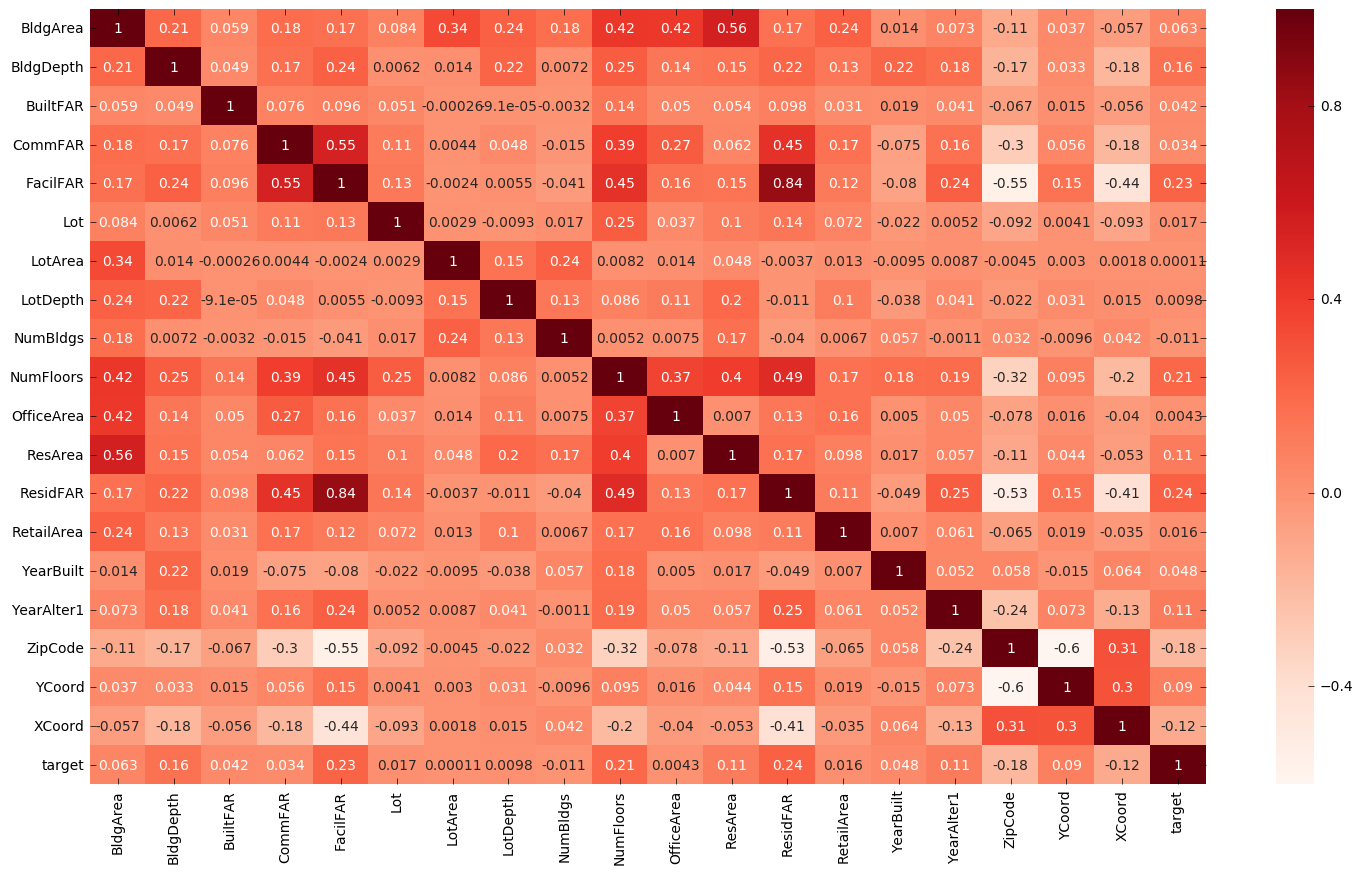

In [14]:
# using Pearson correlation
plt.figure(figsize=(18,10))
cor = df_pluto.corr()
sns.heatmap(cor, annot = True, cmap=plt.cm.Reds)
plt.show()

In [15]:
#Correlation with output variable
cor_target = abs(cor["target"])
#Selecting highly correlated features. Here I set the threshold to be 0.12
relevant_features = cor_target[cor_target>0.12]
relevant_features


BldgDepth    0.158439
FacilFAR     0.228403
NumFloors    0.207587
ResidFAR     0.240607
ZipCode      0.183652
target       1.000000
Name: target, dtype: float64

In [16]:
print(df_pluto[["ResidFAR","FacilFAR"]].corr())

          ResidFAR  FacilFAR
ResidFAR   1.00000   0.83925
FacilFAR   0.83925   1.00000


### I will drop FacilFAR feature and keep ResiFAR feature as they are highly correlated. So the important features are 'BldgDepth', 'ResiFAR', 'NumFloors', 'ZipCode', 'target'. 

In [17]:
important_feature = ['BldgDepth', 'NumFloors', 'ResidFAR', 'ZipCode','target']
df_selected_feature = df_pluto[important_feature]
df_selected_feature.head()

,BldgDepth,NumFloors,ResidFAR,ZipCode,target
0,195.0,10.0,5.4,11201.0,0
1,0.0,12.0,0.0,11201.0,0
2,0.0,0.0,0.0,11201.0,0
3,0.0,0.0,0.0,11201.0,0
4,0.0,0.0,0.0,11201.0,0


## The above analysis gices a rough idea about the data and its general statistics. This type of exploratory analysis helps to better understand feature sets and decide which algorithm may better suit for our problem.

# Random forrest method for feature selection


In [18]:
# data for features set and target

X = df_pluto.drop(["Address", "target", "XCoord", "YCoord"],1)
y = df_pluto["target"]

# feature labels
feat_labels = list(X.columns)

# Split the data into 30% test and 70% training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


In [19]:
# feature scaling

sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)  

/Applications/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda/lib/python3.5/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [20]:
# Create a random forest classifier
clf = RandomForestClassifier(random_state=0, n_jobs=2)

# Train the classifier
clf.fit(X_train, y_train)

importances = clf.feature_importances_

# Print the name and gini importance of each feature
for feature in zip(feat_labels, clf.feature_importances_):
    print(feature)

/Applications/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


('BldgArea', 0.08181545254135023)
('BldgDepth', 0.07345472299053465)
('BuiltFAR', 0.11730482869488035)
('CommFAR', 0.0066170417631416425)
('FacilFAR', 0.024539882684434394)
('Lot', 0.1743092970489188)
('LotArea', 0.07390383201916875)
('LotDepth', 0.050819341007342665)
('NumBldgs', 0.013261942143465221)
('NumFloors', 0.034778119518421434)
('OfficeArea', 0.005831293861948585)
('ResArea', 0.14469136641702499)
('ResidFAR', 0.030626287620683163)
('RetailArea', 0.015814224175080216)
('YearBuilt', 0.0638050806459873)
('YearAlter1', 0.020584920248856997)
('ZipCode', 0.06784236661876061)


## Visulization for feature importance

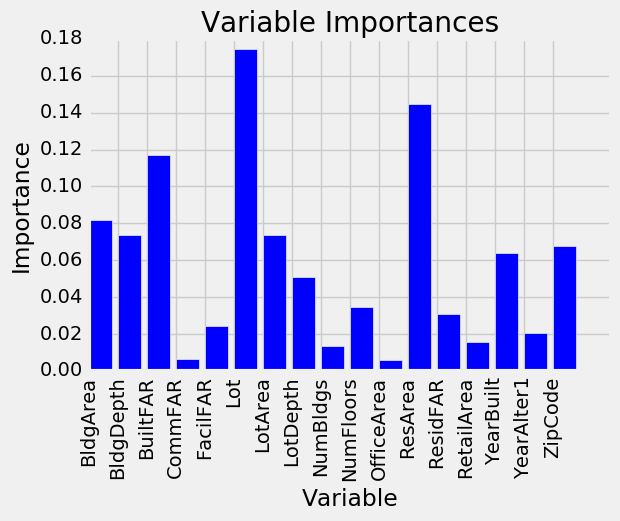

In [21]:
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feat_labels, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [22]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.04
sfm = SelectFromModel(clf, threshold=0.04)

# Train the selector
sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=0.04)

In [23]:
# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

BldgArea
BldgDepth
BuiltFAR
Lot
LotArea
LotDepth
ResArea
YearBuilt
ZipCode


### Create A Data Subset With Only The Most Important Features


In [24]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

### Train A New Random Forest Classifier Using Only Most Important Features


In [25]:
# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(random_state=0, n_jobs=2)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)

/Applications/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

### Compare The Accuracy Of Our Full Feature Classifier To Our Limited Feature Classifier

In [27]:
# Apply The Full Featured Classifier To The Test Data
y_pred = clf.predict(X_test)

# View The Accuracy Of Our Full Feature (19 Features) Model
accuracy_allFeatures = accuracy_score(y_test, y_pred)

In [28]:

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))  

rmse_allFeatures = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

Mean Absolute Error: 0.12798267659578413
Mean Squared Error: 0.12798267659578413
Root Mean Squared Error: 0.35774666538737177


In [29]:
# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature (10 Features) Model
accuracy_importantFeatures = accuracy_score(y_test, y_important_pred)

In [31]:

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_important_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_important_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_important_pred)))  

rmse_importantFeatures = np.sqrt(metrics.mean_squared_error(y_test, y_important_pred))

Mean Absolute Error: 0.1292346356799065
Mean Squared Error: 0.1292346356799065
Root Mean Squared Error: 0.35949219140324384


In [32]:
print('accuracy_allFeatures:', accuracy_allFeatures)
print('rmse_allFeatures:', rmse_allFeatures)
print('accuracy_importantFeatures:', accuracy_importantFeatures)
print('rmse_importantFeatures:', rmse_importantFeatures)

accuracy_allFeatures: 0.8720173234042159
rmse_allFeatures: 0.35774666538737177
accuracy_importantFeatures: 0.8707653643200934
rmse_importantFeatures: 0.35949219140324384


### As one can see with allfeatures the accuracy of the model is 87.2% and with only 9 important features we have accuracy of 87%. So this shows even with smaller set of features we can predict the complaint types accurately.

# <font color=red> Concluding Remark:
## <font color=red> Using Pearson correlation techniques predicts that 'BldgDepth', 'ResiFAR', 'NumFloors', 'ZipCode' are the important features. Furthermore, Random Forest method gives'BldgArea', 'BldgDepth', 'BuiltFAR', 'Lot', 'LotArea', 'ResArea', 'YearBuilt', 'ZipCode' as an important features. The accuracy score shows that using these important features have 87% accuracy. By using these two methods we are confident that out model is good enough to use for prediction for out of sample data and detect the correct housing characterstics that are highly correlated to complaint type.